In [16]:
# from google.colab import drive
from pathlib import Path
# drive.mount('/content/gdrive', force_remount=True)
%cd "/content/drive/Othercomputers/my_mac/Coding_stuff/Projects/Surface_Predictor"

/content/drive/Othercomputers/my_mac/Coding_stuff/Projects/Surface_Predictor


In [3]:
creds = '...'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
  print('entered')
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write_text(creds)
  cred_path.chmod(0o600)

entered


In [ ]:
# !kaggle competitions download -c career-con-2019 -p ./data/
# !unzip ./data/X_test.csv.zip -d ./data
# !unzip ./data/X_train.csv.zip -d ./data
# !rm ./data/X_train.csv.zip ./data/X_test.csv.zip

In [4]:
%pip install -Uqq pytorch-lightning torchmetrics wandb

     |████████████████████████████████| 527 kB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 397 kB 95.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 107.5 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 952 kB 72.3 MB/s eta 0:00:01
     |████████████████████████████████| 596 kB 76.6 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 63.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 66.9 MB/s eta 0:00:01
     |████████████████████████████████| 180 kB 96.6 MB/s eta 0:00:01
     |████████████████████████████████| 144 kB 75.8 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 2.0 MB/s  eta 0:00:01
     |████████████████████████████████| 144 kB 96.7 MB/s eta 0:00:01
     |████████████████████████████████| 94 kB 4.0 MB/s  eta 0:00:01
     |████████████████████████████████| 271 kB 76.7 MB/s eta 0:00:01
ERROR: pip's dependency resolver doe

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import wandb
from tqdm.auto import tqdm 

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import WandbLogger
import torchmetrics

from pylab import rcParams
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [6]:
%matplotlib inline
%config InlinBackend.figure_format = 'retina'
sns.set_style(style= 'whitegrid')
rcParams['figure.figsize'] = 14,9

In [7]:
pl.seed_everything(42)

Global seed set to 42


42

In [10]:
!wandb login

wandb: Currently logged in as: phade160 (use `wandb login --relogin` to force relogin)


In [14]:
!pwd

/content/drive/Othercomputers/my_mac/Coding_stuff/Projects/Surface_Predictor/notebooks


## Load Data

In [17]:
x_train = pd.read_csv('./data/raw/X_train.csv', low_memory=False)
y_train = pd.read_csv('./data/raw/y_train.csv', low_memory=False)
x_train

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.104950,-0.105970,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.104950,-0.105960,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.142740,3.27180,2.0115,-9.0063
487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.132380,4.42750,3.0696,-8.1257
487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.138940,2.70480,4.2622,-8.1443
487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.130210,2.54100,4.7130,-9.4435


In [18]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487680 entries, 0 to 487679
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 487680 non-null  object 
 1   series_id              487680 non-null  int64  
 2   measurement_number     487680 non-null  int64  
 3   orientation_X          487680 non-null  float64
 4   orientation_Y          487680 non-null  float64
 5   orientation_Z          487680 non-null  float64
 6   orientation_W          487680 non-null  float64
 7   angular_velocity_X     487680 non-null  float64
 8   angular_velocity_Y     487680 non-null  float64
 9   angular_velocity_Z     487680 non-null  float64
 10  linear_acceleration_X  487680 non-null  float64
 11  linear_acceleration_Y  487680 non-null  float64
 12  linear_acceleration_Z  487680 non-null  float64
dtypes: float64(10), int64(2), object(1)
memory usage: 48.4+ MB


In [19]:
y_train

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles
...,...,...,...
3805,3805,55,tiled
3806,3806,67,wood
3807,3807,48,fine_concrete
3808,3808,54,tiled


In [ ]:
y_train.surface.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Distribution of target (surface) ')
plt.show()

## Preprocessing

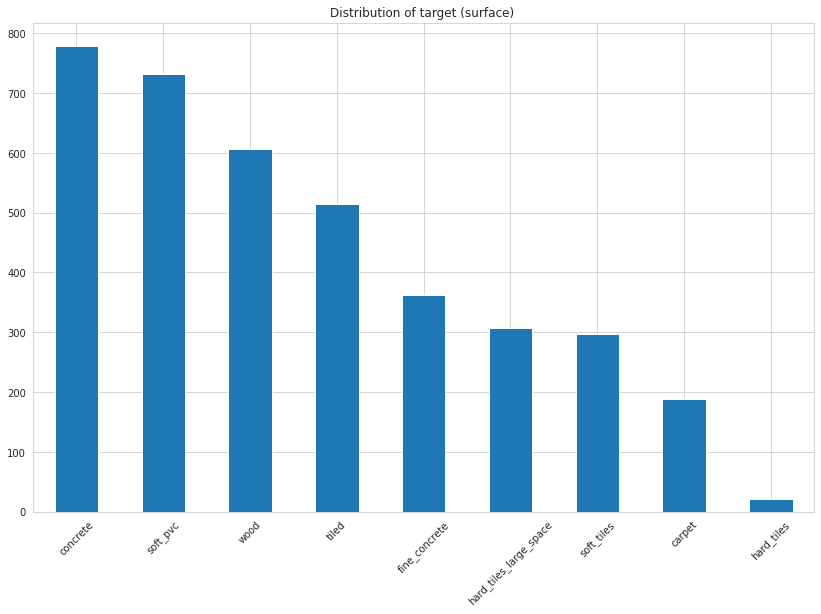

In [20]:
y_train.surface.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Distribution of target (surface) ')
plt.show()

In [22]:
label_encoder =  LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)

In [23]:
label_encoder.classes_

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [25]:
encoded_labels[:5], list(y_train.surface[:5])

(array([2, 1, 1, 1, 6]),
 ['fine_concrete', 'concrete', 'concrete', 'concrete', 'soft_tiles'])

In [26]:
y_train['label'] = encoded_labels
y_train

,series_id,group_id,surface,label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6
...,...,...,...,...
3805,3805,55,tiled,7
3806,3806,67,wood,8
3807,3807,48,fine_concrete,2
3808,3808,54,tiled,7


In [27]:
x_train

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.104950,-0.105970,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.104950,-0.105960,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.142740,3.27180,2.0115,-9.0063
487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.132380,4.42750,3.0696,-8.1257
487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.138940,2.70480,4.2622,-8.1443
487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.130210,2.54100,4.7130,-9.4435


In [28]:
#we dont need the first 3 cols
feature_columns = x_train.columns.to_list()[3:]
feature_columns

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

## Build sequences

In [30]:
#it looks like the sequences have been grouped for us
x_train.series_id.value_counts()

0       128
2544    128
2532    128
2533    128
2534    128
       ... 
1274    128
1275    128
1276    128
1277    128
3809    128
Name: series_id, Length: 3810, dtype: int64

In [31]:
sequences = []
for series_id, group in x_train.groupby('series_id'):
  sequence_features = group[feature_columns]
  label = y_train[y_train.series_id == series_id].iloc[0].label
  sequences.append((sequence_features, label))

In [32]:
sequences[0]

(     orientation_X  orientation_Y  ...  linear_acceleration_Y  linear_acceleration_Z
 0         -0.75853       -0.63435  ...                2.10300                -9.7532
 1         -0.75853       -0.63434  ...                1.50640                -9.4128
 2         -0.75853       -0.63435  ...                1.59220                -8.7267
 3         -0.75852       -0.63436  ...                1.09930               -10.0960
 4         -0.75852       -0.63435  ...                1.46890               -10.4410
 ..             ...            ...  ...                    ...                    ...
 123       -0.75943       -0.63316  ...                1.79890                -6.8687
 124       -0.75945       -0.63313  ...                2.35620                -6.8926
 125       -0.75949       -0.63309  ...                0.97328                -9.9795
 126       -0.75950       -0.63307  ...                0.34931               -11.9770
 127       -0.75953       -0.63306  ...               

In [33]:
train_sequences, val_sequences = train_test_split(sequences, test_size=0.2)
len(train_sequences), len(val_sequences)

(3048, 762)

In [34]:
#sanity check
len(train_sequences), len(val_sequences)
print('all train seq shape check: ',[(train_sequences[i][0].shape) for i in range(len(train_sequences)) if (train_sequences[i][0].shape) != (128, 10)])
# print('all train label shape check: ',[len(train_sequences[i][1]) for i in range(len(train_sequences)) if len(train_sequences[i][1]) != 10])
print('all train seq shape check: ',[(val_sequences[i][0].shape) for i in range(len(val_sequences)) if (val_sequences[i][0].shape) != (128, 10)])
# print('all train label shape check: ',[len(val_sequences[i][1]) for i in range(len(val_sequences)) if len(val_sequences[i][1]) != 10])

all train seq shape check:  []
all train seq shape check:  []


## Dataset and Datamodule

In [36]:

class SurfaceDataset(Dataset):

  def __init__(self, sequences) -> None:
      super().__init__()
      self.sequences = sequences

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, index):
    sequence, label = self.sequences[index]
    return dict(
      sequence=torch.Tensor(sequence.to_numpy()),
      label=torch.tensor(label).long()
    )



In [37]:
class SurfaceDatamodule(pl.LightningDataModule):

  def __init__(self, train_sequences, val_sequences, batch_size):
    super().__init__()
    self.train_sequences = train_sequences
    self.val_sequences = val_sequences
    self.batch_size = batch_size

  def setup(self, stage=None):
    self.train_dataset = SurfaceDataset(self.train_sequences)
    self.val_dataset = SurfaceDataset(self.val_sequences)

  def train_dataloader(self):
      return DataLoader(self.train_dataset, 
                        batch_size=self.batch_size,
                        num_workers=3)
      
  def val_dataloader(self):
      return DataLoader(self.val_dataset,
                        batch_size=self.batch_size,
                        num_workers=2)


## Architecture and PL Module

In [38]:

class SurfaceModel(nn.Module):

  def __init__(self, n_features, n_classes, n_hidden,dropout, n_layers=3):
    super().__init__()
    print(dropout)
    self.n_fearues = n_features
    self.n_classes = n_classes
    self.n_hidden = n_hidden
    self.n_layers = n_layers
    self.dropout = dropout

    self.lstm = nn.LSTM(
        input_size =self.n_fearues,
        hidden_size = self.n_hidden,
        num_layers = self.n_layers,
        dropout = self.dropout,
        batch_first = True
    )
    self.cassifier = nn.Linear(self.n_hidden, self.n_classes)

  def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden,_) = self.lstm(x)
        out = hidden[-1]
        return self.cassifier(out)

In [40]:
class SurfacePredictor(pl.LightningModule):
  def __init__(self, n_features, n_classes, n_hidden, seq_length, dropout, n_layers=3, lr=0.0001):
    super().__init__()
    self.lr = lr 
    self.seq_length =seq_length
    self.n_features = n_features

    self.model = SurfaceModel(n_features, n_classes, n_hidden, n_layers=n_layers,dropout=dropout)
    self.criterion = nn.CrossEntropyLoss()
    self.train_ac = torchmetrics.Accuracy()
    self.val_ac = torchmetrics.Accuracy()
    self.save_hyperparameters()


  def forward(self, x, labels=None):
    output = self.model(x)

    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
      return loss, output

    return output


  def training_step(self, batch, batch_idx):
    sequences = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_ac = self.train_ac(predictions, labels)

    self.log('train_loss', loss, prog_bar=True, logger=True)
    self.log('train_accuracy', step_ac, prog_bar=True, logger=True)

    return dict(loss=loss, accuracy=step_ac)

  def validation_step(self, batch, batch_idx):
    sequences = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_ac = self.train_ac(predictions, labels)

    self.log('val_loss', loss, prog_bar=True, logger=True)
    self.log('val_accuracy', step_ac, prog_bar=True, logger=True)

    return dict(loss=loss, accuracy=step_ac, loggits=outputs)


  def validation_epoch_end(self, validation_step_outputs):
    dummyImput = torch.zeros(
        (1, self.seq_length, self.n_features), device=self.device)
    model_filename = f"model_{str(self.global_step).zfill(5)}.onnx"
    torch.onnx.export(self, dummyImput, model_filename, opset_version=11)
    # wandb.save(model_filename,)
    outputs = [out['loggits'] for out in validation_step_outputs]
    flattened_outputs = torch.flatten(
          torch.cat(outputs))
    self.logger.experiment.log(
    {'valid/logits': wandb.Histogram(flattened_outputs.to('cpu')),
      'epoch': self.current_epoch}
    )


  def configure_optimizers(self):
    return torch.optim.AdamW(self.parameters(), lr=self.lr)
 

In [35]:
n_epoch = 10
bs = 256
n_features = len(feature_columns)
n_classes = len(label_encoder.classes_)
n_hidden = 128
seq_length= 128

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best_checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4, verbose=True)
progress_bar = TQDMProgressBar(refresh_rate=30)

callbacks = [early_stopping_callback, checkpoint_callback, progress_bar]
logger = WandbLogger(name='onnx', save_dir='./logs', project='surface_pred',settings=wandb.Settings(symlink=False))
# wandb.init(settings=wandb.Settings(symlink=False))
trainer = pl.Trainer(gpus = 1,
                     max_epochs = n_epoch,
                     logger= logger,
                     callbacks = callbacks,
                     precision=16)

10

In [ ]:
params23 ={
    'n_features': len(feature_columns),
    "n_classes": len(label_encoder.classes_),
    "dropout": 0.4,
    "n_hidden": 512,
    "batch_size": 512,
    "lr": 0.00426   
    }

In [ ]:
def train(params, name):

    # set up W&B logger
    wandb_logger = WandbLogger(log_model=True)  # log final model


    # setup data
    data_module =SurfaceDatamodule(train_sequences, val_sequences, batch_size=params['batch_size'])

    # setup model - note how we refer to sweep parameters with wandb.config
    model = SurfacePredictor(n_features, n_classes,params['n_hidden'], seq_length, dropout = params['dropout'], lr = params['lr'])

    # early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4, verbose=True)
    progress_bar = TQDMProgressBar(refresh_rate=30)

    logger = WandbLogger(name=name, save_dir='./logs', project='surface_pred')
    callbacks = [progress_bar]

    # setup Trainer
    trainer = pl.Trainer(gpus = 1,
                        max_epochs = 250,
                        logger= logger,
                        callbacks = callbacks,
                        precision=16)

    # train
    trainer.fit(model, datamodule=data_module)
    wandb.finish()

In [42]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found
